In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import os
import sys

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
from pokie import pokie, pokie_bootstrap, get_device

# Linear Regression – Posterior Inference and Pokie Evaluation

We consider a linear regression setup where we aim to infer the posterior distribution over weights $\boldsymbol{\theta} = [m, b]^\top$ of the linear model:

$$
y = mx + b + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)
$$

---

## 1. Likelihood

Given $x_i \in \mathbb{R}$ and $y_i \in \mathbb{R}$, the model is:

$$
y_i \sim \mathcal{N}(x_i^\top \boldsymbol{\theta}, \sigma^2)
$$

where $x_i = [x_i, 1]$ is the augmented input including bias, and $\sigma^2$ is the observation noise variance.

---

## 2. Prior

We place a Gaussian prior on the weights:

$$
\boldsymbol{\theta} \sim \mathcal{N}(\boldsymbol{\mu}_0, \Sigma_0)
$$

This leads to a conjugate posterior.

---

## 3. Posterior

The exact posterior is Gaussian:

$$
\Sigma_{\text{post}} = \left( \Sigma_0^{-1} + A^\top \Sigma_n^{-1} A \right)^{-1}
$$

$$
\boldsymbol{\mu}_{\text{post}} = \Sigma_{\text{post}} \left( A^\top \Sigma_n^{-1} \mathbf{y} + \Sigma_0^{-1} \boldsymbol{\mu}_0 \right)
$$

---

## 4. Posterior Sampling

We sample:

$$
\boldsymbol{\theta}^{(i)} \sim \mathcal{N}(\boldsymbol{\mu}_{\text{post}}, \Sigma_{\text{post}} + \epsilon I)
$$

We evaluate Pokie for each model, comparing posterior calibration across noise levels.

In [2]:
# -------------------------------
# 0. CONFIGURATION
# -------------------------------
num_gt        = 500               # Number of ground‑truth parameter draws
num_samples   = 500               # Posterior samples per GT
n             = 100               # Observations per GT
true_sigma    = 1.0               # Observation noise σ
prior_mu      = np.zeros(2)       # Prior mean vector [m0, b0]
prior_Sigma   = np.eye(2) * 1.0   # Prior covariance (τ² I)
noise_levels  = [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
num_noise     = len(noise_levels)

In [3]:
# -------------------------------
# 1. Storage
# -------------------------------
# ground_truths: shape (num_gt, 2) for [m*, b*]
# ground_truths = np.random.uniform(-5, 5, size=(num_gt, 2))
m_stars       = np.random.uniform(-1,  1, size=num_gt)
b_stars       = np.random.uniform(-5,  5, size=num_gt)
ground_truths = np.stack([m_stars, b_stars], axis=1)  # shape (num_gt, 2)

# posteriors: shape (num_noise, num_gt, num_samples, 2)
posteriors = np.zeros((num_noise, num_gt, num_samples, 2))

In [4]:
# -------------------------------
# 2. Posterior Sampling Loop
# -------------------------------
for gt_idx in tqdm(range(num_gt), desc="Sampling Linear-Regression Posteriors"):
    m_star, b_star = ground_truths[gt_idx]
    # Generate data
    x = np.random.uniform(-1, 1, size=n)
    y = m_star * x + b_star \
        + np.random.normal(0, true_sigma, size=n)
    # Build design
    A = np.stack([x, np.ones(n)], axis=1)  # shape (n,2)
    
    # Precompute posterior natural parameters
    Sigma_n_inv = np.eye(n) / (true_sigma**2)
    Precision_post = np.linalg.inv(prior_Sigma) + A.T @ Sigma_n_inv @ A
    Sigma_post     = np.linalg.inv(Precision_post)
    mu_post        = Sigma_post @ (A.T @ Sigma_n_inv @ y + np.linalg.inv(prior_Sigma) @ prior_mu)
    
    # Draw posterior samples, with optional bias inflation
    for nl_idx, scale in enumerate(noise_levels):
        # simulate mis‑calibration by shifting the posterior mean
        delta = np.sqrt(scale) * np.array([1.0, 1.0])  # same shift for both m, b
        biased_mean = mu_post + delta
        # sample from N(biased_mean, Sigma_post)
        posteriors[nl_idx, gt_idx] = np.random.multivariate_normal(
            biased_mean, Sigma_post, size=num_samples
        )

Sampling Linear-Regression Posteriors: 100%|██████████| 500/500 [00:00<00:00, 1135.70it/s]


In [5]:
# -------------------------------
# 3. Normalization for Pokie
# -------------------------------
# We'll flatten all posterior samples + the GT vector, per-parameter, 
# then min/max rescale to [0,1] so Pokie operates on comparable scales.

gt_norm        = np.zeros_like(ground_truths)
posterior_norm = np.zeros_like(posteriors)

for gt_idx in range(num_gt):
    # stack all samples for both noise levels, plus the GT itself
    all_samps = np.vstack([
        posteriors[nl, gt_idx] for nl in range(num_noise)
    ] + [ground_truths[gt_idx:gt_idx+1]])
    
    mins = all_samps.min(axis=0)
    maxs = all_samps.max(axis=0)
    span = np.maximum(maxs - mins, 1e-8)
    
    # normalize
    gt_norm[gt_idx] = (ground_truths[gt_idx] - mins) / span
    for nl in range(num_noise):
        posterior_norm[nl, gt_idx] = (posteriors[nl, gt_idx] - mins) / span

In [6]:
# -------------------------------
# 4. Pokie Evaluation
# -------------------------------
# Assume you have a function pokie(gt_norm, posterior_norm, num_runs)
# that returns (raw_probs, calibrated_probs, n_over_N_vals).
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
posterior_norm   = torch.tensor(posterior_norm, dtype=torch.float32, device=device)
gt_norm = torch.tensor(gt_norm,   dtype=torch.float32, device=device)


results, calibrated, n_over_N_vals = pokie(
    gt_norm, posterior_norm, num_runs=100
)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print("Noise Levels:", noise_levels)
print("Raw Pokie:", results)
print("Calibrated Pokie:", calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


Noise Levels: [0.001, 0.01, 0.1, 0.15, 0.2, 0.25]
Raw Pokie: [0.18707585 0.18039118 0.16041878 0.15865962 0.15700988 0.15644467]
Calibrated Pokie: [0.6611151  0.6374919  0.56691056 0.5606938  0.55486375 0.5528663 ]


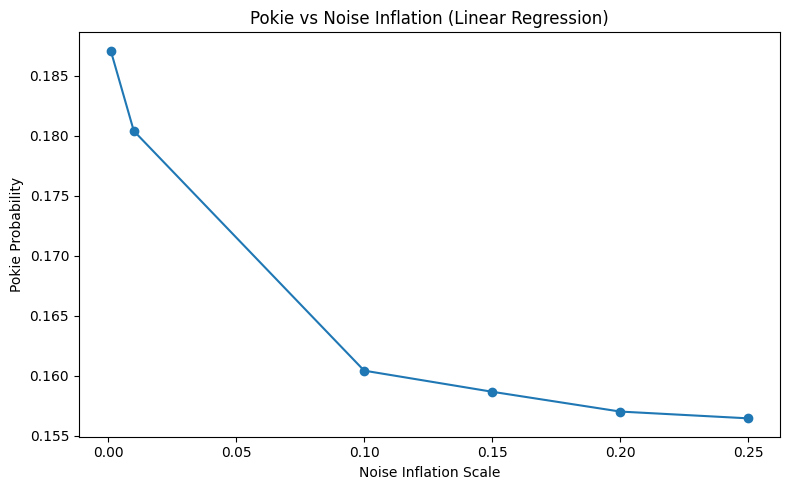

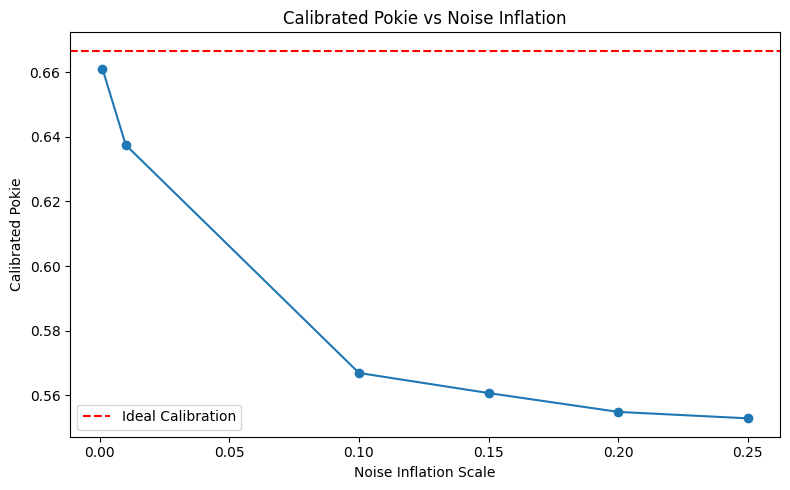

In [7]:
# -------------------------------
# 5. Plotting
# -------------------------------
plt.figure(figsize=(8,5))
plt.plot(noise_levels, results, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (Linear Regression)')
plt.tight_layout()
plt.savefig("../PLots/Linear_Regression/Pokie_Linear_Regression.pdf")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(noise_levels, calibrated, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Calibrated Pokie')
plt.title('Calibrated Pokie vs Noise Inflation')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig("../PLots/Linear_Regression/Pokie_Linear_Regression_Calibrated.pdf")
plt.show()

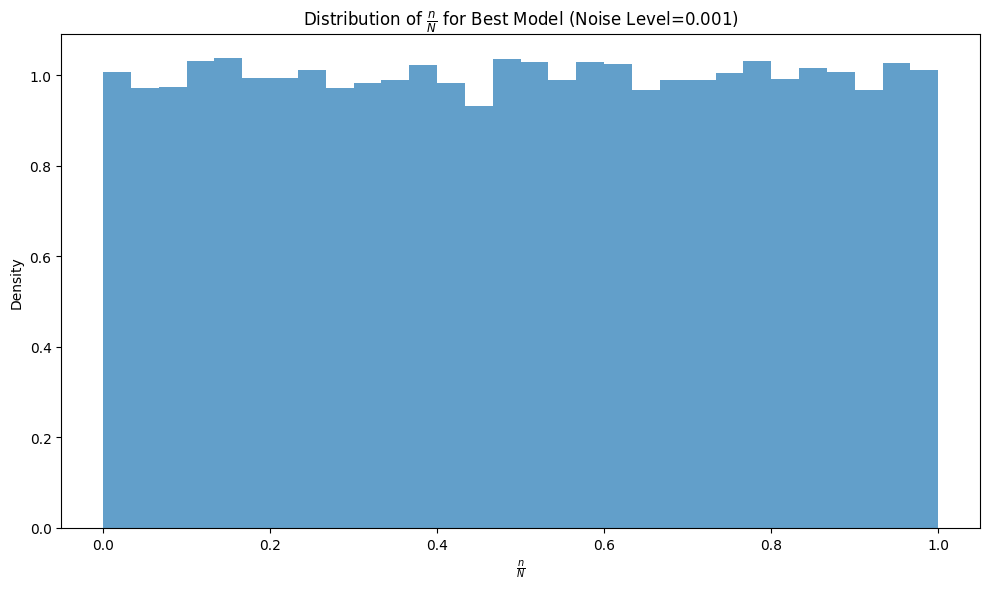

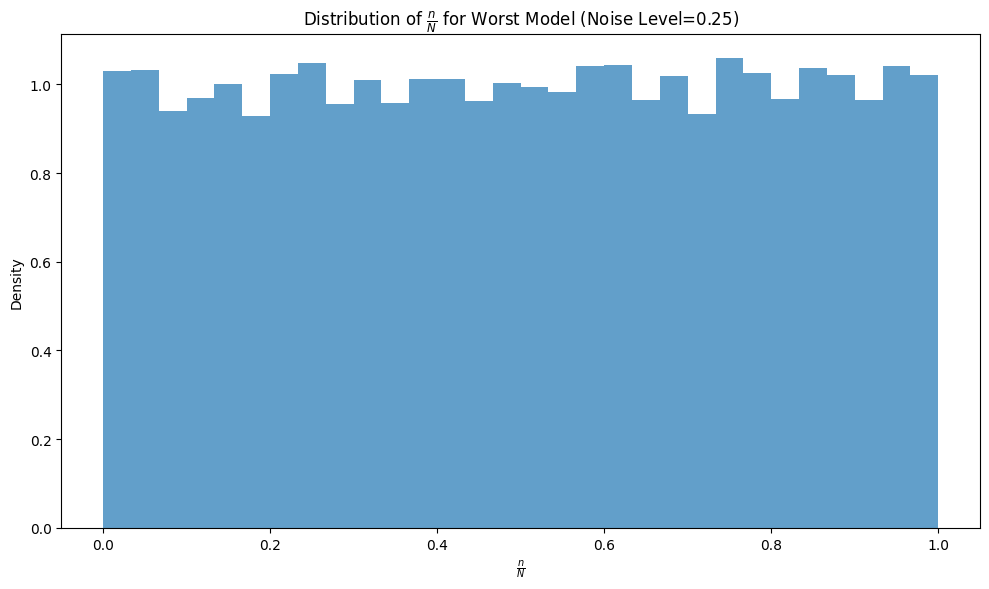

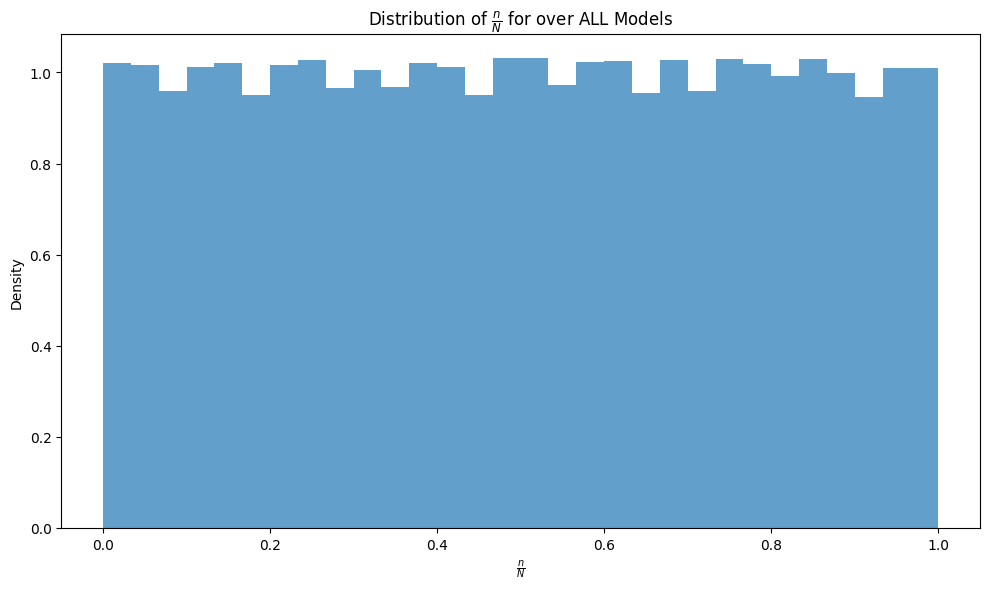

In [8]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (Noise Level={noise_levels[best_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Linear_Regression/Pokie_Best_Model_n_over_N_Linear_Regression.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (Noise Level={noise_levels[worst_model_idx]})")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Linear_Regression/Pokie_Worst_Model_n_over_N_Linear_Regression.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("../PLots/Linear_Regression/Pokie_n_over_N_Linear_Regression.pdf")
plt.show()